In [32]:
## EU-DV-2 Threshold definition  – time-series
# The interface allow the expert user to define a threshold and select a 
# pollutant, a time window and a province and visualize a time series showing which days the 
# threshold has been exceeded and a percentage (exceeded days/total days).

# - button select a pollutant
# - button select threshold
# - button select start day
# - button select end day
# - button select start mounth
# - button select end mounth
# - button select start year
# - button select end year
# - button select a province 


In [7]:
import ipywidgets as widgets
from IPython.display import display
import requests
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime

# Utility Function to Read API Responses

def read_response(response):
    try:
        return response.json()
    except requests.exceptions.JSONDecodeError:
        print("Invalid JSON response!")
        print("Response content:", response.text)
        return None
    
# Get List of Available Provinces

def get_provinces_list():
    response = requests.get("http://127.0.0.1:5000/api/provinces")
    return read_response(response) or []


# Get List of Available Pollutants

def get_pollutants_list():
    response = requests.get("http://127.0.0.1:5000/api/pollutants")
    return read_response(response) or []

# Get startdate and enddata possible

def get_data_dict():
    response = requests.get("http://127.0.0.1:5000/api/data")
    return read_response(response) or []

# Slider soglia
slider_soglia = widgets.IntSlider(
    value=0,
    min=0,
    max=80,
    step=1,
    description='Soglia:',
    continuous_update=False
)


# Dropdowns e Output UI (creazione degli elementi interattivi)

provincia_dropdown = widgets.Dropdown(
    options=get_provinces_list(),
    description="Province:"
)

pollutant_dropdown = widgets.Dropdown(
    options=get_pollutants_list(),
    description="pollutant:"
)

output = widgets.Output()


# Date picker per inizio e fine
data = get_data_dict()
start_date = widgets.DatePicker(description='Inizio:')
end_date = widgets.DatePicker(description='Fine:')

display(widgets.VBox([
    provincia_dropdown,
    pollutant_dropdown,
    slider_soglia,
    widgets.HBox([start_date, end_date]),
    output
]))


In [12]:
from datetime import date

# Assicurati che start_date.value ed end_date.value non siano None
if start_date.value and end_date.value:
    data = {
        "var_pollutant": pollutant_dropdown.value,
        "var_start_date": start_date.value.strftime('%Y-%m-%d 00:00:00'),
        "var_end_date": end_date.value.strftime('%Y-%m-%d 23:59:59'),
        "var_province": provincia_dropdown.value,
        "var_threshold": slider_soglia.value
    }

data



{'var_pollutant': 'Ozono',
 'var_start_date': '2024-12-20 00:00:00',
 'var_end_date': '2024-12-22 23:59:59',
 'var_province': 'MILANO',
 'var_threshold': 50}

In [13]:
# EU-DV-2 

import requests
import pandas as pd
import json

t=requests.post(url="http://127.0.0.1:5000/api/EU_DV_2", json=data) 

try:
    data = t.json() #This will convert the response to a json object
    print("The query returned", len(data), "rows")
    print(type(data))
except requests.exceptions.JSONDecodeError:
    print("Risposta non valida JSON!")
    print("Contenuto della risposta:", t.text)
    data = None

df = pd.DataFrame(data)
print(df)

df['data'] = pd.to_datetime(df['data'], errors='raise')
exceeded_days = df['data'].dt.date.nunique()
print(f"Giorni unici: {exceeded_days}")

The query returned 86 rows
<class 'list'>
                             data  valore
0   Fri, 20 Dec 2024 15:00:00 GMT    51.5
1   Fri, 20 Dec 2024 05:00:00 GMT    51.5
2   Fri, 20 Dec 2024 06:00:00 GMT    51.3
3   Fri, 20 Dec 2024 10:00:00 GMT    52.4
4   Fri, 20 Dec 2024 11:00:00 GMT    63.6
..                            ...     ...
81  Sat, 21 Dec 2024 03:00:00 GMT    58.3
82  Sat, 21 Dec 2024 13:00:00 GMT    52.4
83  Sat, 21 Dec 2024 14:00:00 GMT    51.2
84  Sat, 21 Dec 2024 15:00:00 GMT    51.0
85  Sat, 21 Dec 2024 16:00:00 GMT    50.2

[86 rows x 2 columns]
Giorni unici: 2


In [15]:
data = {"var_province": provincia_dropdown.value.upper(),
        "var_pollutant": pollutant_dropdown.value,
        "var_start_date": start_date.value.strftime('%Y-%m-%d 00:00:00'),
        "var_end_date": end_date.value.strftime('%Y-%m-%d 23:59:59'),
        } 

t=requests.post(url="http://127.0.0.1:5000/api/DV_7provinciamod", json=data) 

try:
    data = t.json() #This will convert the response to a json object
    print("The query returned", len(data), "rows")
    print(type(data))
except requests.exceptions.JSONDecodeError:
    print("Risposta non valida JSON!")
    print("Contenuto della risposta:", t.text)
    data = None

df = pd.DataFrame(data)
print(df)

df['data'] = pd.to_datetime(df['data'], errors='raise')
totaldays = df['data'].dt.date.nunique()
print(f"Giorni unici: {totaldays}")


The query returned 432 rows
<class 'list'>
                              data  valore
0    Fri, 20 Dec 2024 00:00:00 GMT     1.0
1    Fri, 20 Dec 2024 01:00:00 GMT     0.8
2    Fri, 20 Dec 2024 02:00:00 GMT     0.2
3    Fri, 20 Dec 2024 03:00:00 GMT     7.0
4    Fri, 20 Dec 2024 04:00:00 GMT    32.0
..                             ...     ...
427  Sun, 22 Dec 2024 19:00:00 GMT     3.3
428  Sun, 22 Dec 2024 20:00:00 GMT     4.8
429  Sun, 22 Dec 2024 21:00:00 GMT     2.8
430  Sun, 22 Dec 2024 22:00:00 GMT     2.6
431  Sun, 22 Dec 2024 23:00:00 GMT     2.8

[432 rows x 2 columns]
Giorni unici: 3


In [16]:
# visualize a time series showing which days the threshold has been exceeded and a percentage (exceeded days/total days).

percentage=0
percentage=(exceeded_days/totaldays)*100
print(f"Percentage of days in which the threshold has been exceeded : {percentage}")


Percentage of days in which the threshold has been exceeded : 66.66666666666666


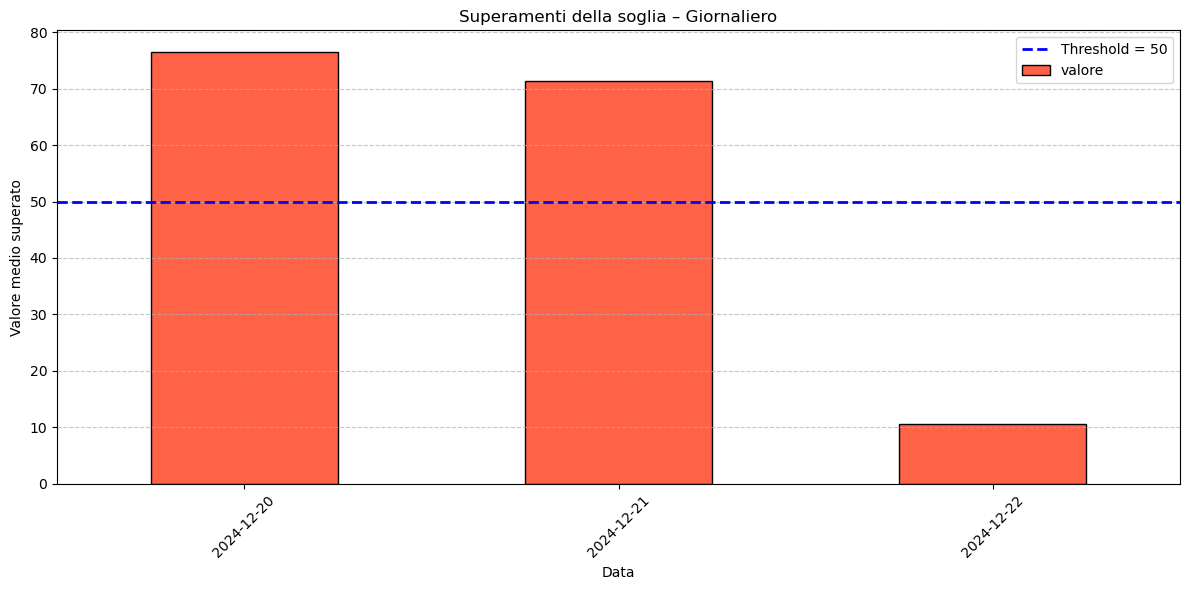

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assumendo che df sia il DataFrame dei superamenti
df['data'] = pd.to_datetime(df['data'])

# Raggruppamento per giorno
df_grouped = df.groupby(df['data'].dt.date)['valore'].max()

# Valore della soglia da visualizzare
threshold = slider_soglia.value  # oppure impostalo direttamente, es: threshold = 50

# Crea l'istogramma
plt.figure(figsize=(12, 6))
df_grouped.plot(kind='bar', color='tomato', edgecolor='black')

# Aggiungi la linea orizzontale della soglia
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')

plt.title('Superamenti della soglia – Giornaliero')
plt.xlabel('Data')
plt.ylabel('Valore medio superato')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

